# Multi-planetary search

In [1]:
# in order to run on all CPUs
import os
import jax

jax.config.update("jax_enable_x64", True)
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

In this notebook, we use `nuance` to search for the transiting exoplanets with the following parameters:

In [2]:
truth = [
    {"epoch": 0.5, "duration": 0.03, "period": 1.8, "depth": 3e-3},
    {"epoch": 0.2, "duration": 0.03, "period": 0.8, "depth": 1e-3},
]

## Generating the data

Let generate this transit signals together with correlated noise

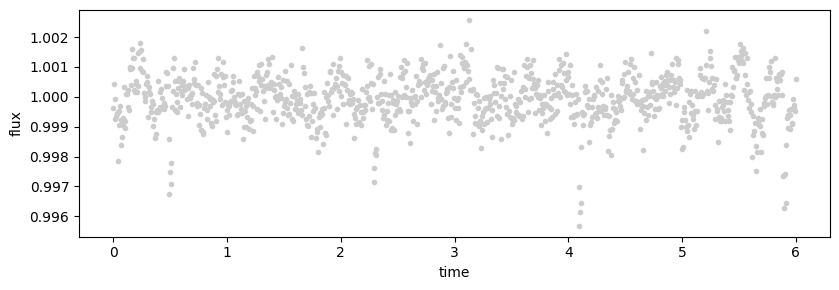

In [3]:
import tinygp
import numpy as np
import matplotlib.pyplot as plt
from nuance import core

# measurements
time = np.linspace(0, 6, 1000)
error = 0.0005
transits = [
    p["depth"] * core.transit(time, p["epoch"], p["duration"], p["period"])
    for p in truth
]
diff_transit_flux = np.sum(transits, 0) + 1.0

# GP
kernel = tinygp.kernels.quasisep.SHO(
    np.pi / (truth[1]["duration"] * 5), 8.0, truth[1]["depth"] / 2
)
gp = tinygp.GaussianProcess(kernel, time, diag=error**2, mean=0.0)
flux = diff_transit_flux + gp.sample(jax.random.PRNGKey(40))

plt.figure(None, (8.5, 3))
plt.plot(time, flux, ".", c="0.8")
plt.ylabel("flux")
plt.xlabel("time")

plt.tight_layout()

## The *linear search*

We start by performing the *linear search* over all times (considered as potential transit epochs) and on a wide range of durations.

In [4]:
from nuance.linear_search import linear_search

epochs = time.copy()
durations = np.linspace(0.01, 0.2, 15)

ls = linear_search(time, flux, gp=gp)(epochs, durations)

100%|██████████| 1008/1008 [00:00<00:00, 3359.78it/s]


```{note}
Notice how we reused the same Gaussian Process used to generate the data. In practice, a kernel need to be chosen and its hyper-parameters optimized. See the [GP optimization tutorial](gp.ipynb)
```

Whatever the number of planets we will look for, this step needs to be done only once.

## The *periodic search*
### First planet

We can now perform the periodic search

In [5]:
import matplotlib.pyplot as plt
from nuance.periodic_search import periodic_search

periods = np.linspace(0.3, 4.0, 4000)

snr_function = jax.jit(core.snr(time, flux, gp=gp))
ps_function = periodic_search(epochs, durations, ls, snr_function)
snr, params = ps_function(periods)

t0, D, P = params[np.argmax(snr)]

print(
    "\n".join(
        [f"{n}: {v:.3f}" for n, v in zip(["epoch", "duration", "period"], [t0, D, P])]
    )
)

/Users/lgarcia/mambaforge/envs/nuance/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4000/4000 [00:00<00:00, 6687.49it/s]

epoch: 0.503
duration: 0.024
period: 1.798


and plot the SNR periodogram

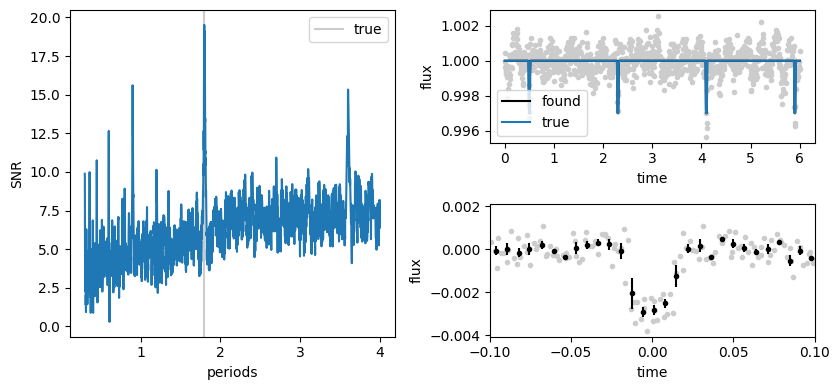

In [6]:
from nuance import utils

fig = plt.figure(figsize=(8.5, 4))

linear, found, noise = core.separate_models(time, flux, gp=gp)(t0, D, P)

transit_prams = truth[0]

ax = plt.subplot(121, xlabel="periods", ylabel="SNR")
ax.axvline(transit_prams["period"], c="0.8", ls="-", label="true")
ax.plot(periods, snr)
ax.legend()

ax = plt.subplot(222, xlabel="time", ylabel="flux")
ax.plot(time, flux, ".", c="0.8")
ax.plot(time, found + 1, c="k", label="found")
ax.plot(time, transits[0] + 1, c="C0", label="true")
ax.legend()

ax = plt.subplot(224, xlabel="time", ylabel="flux", xlim=(-0.1, 0.1))
phi = utils.phase(time, t0, P)
detrended = flux - noise - linear
plt.plot(phi, detrended, ".", c=".8")
bx, by, be = utils.binn_time(phi, detrended, bins=10 / 60 / 24)
plt.errorbar(bx, by, yerr=be, fmt=".", c="k")

plt.tight_layout()

This corresponds to the first transit signal injected.

### Second search

To look for a second planetary candidate, we can mask the current candidate with

In [7]:
from tinygp import GaussianProcess

phase = utils.phase(epochs, t0, P)
mask = np.abs(phase) > 2 * D
masked_gp = GaussianProcess(gp.kernel, time[mask], diag=gp.variance[mask])
masked_ls = np.array(ls)[:, mask]

and perform the second *periodic search*

```{note}
Again, we only have to perform another *periodic search*, reusing the products of the *linear search* without loss of sensitivity
``` 

In [8]:
snr_function = jax.jit(core.snr(time[mask], flux[mask], gp=masked_gp))
ps_function = periodic_search(epochs[mask], durations, masked_ls, snr_function)
snr, params = ps_function(periods)

t0, D, P = params[np.argmax(snr)]

print(
    "\n".join(
        [f"{n}: {v:.3f}" for n, v in zip(["epoch", "duration", "period"], [t0, D, P])]
    )
)

/Users/lgarcia/mambaforge/envs/nuance/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4000/4000 [00:00<00:00, 6430.59it/s]

epoch: 0.204
duration: 0.024
period: 0.800


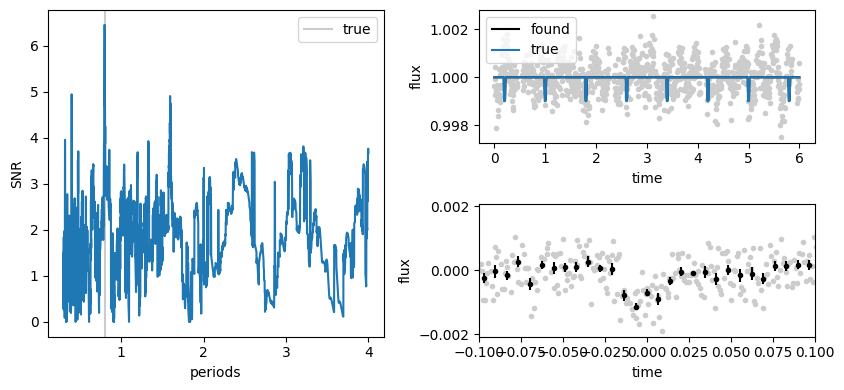

In [9]:
from nuance import utils

fig = plt.figure(figsize=(8.5, 4))

linear, found, noise = core.separate_models(time[mask], flux[mask], gp=masked_gp)(
    t0, D, P
)

transit_prams = truth[1]

ax = plt.subplot(121, xlabel="periods", ylabel="SNR")
ax.axvline(transit_prams["period"], c="0.8", ls="-", label="true")
ax.plot(periods, snr)
ax.legend()

ax = plt.subplot(222, xlabel="time", ylabel="flux")
ax.plot(time[mask], flux[mask], ".", c="0.8")
ax.plot(time[mask], found + 1, c="k", label="found")
ax.plot(time, transits[1] + 1, c="C0", label="true")
ax.legend()

ax = plt.subplot(224, xlabel="time", ylabel="flux", xlim=(-0.1, 0.1))
phi = utils.phase(time[mask], t0, P)
detrended = flux[mask] - noise - linear
plt.plot(phi, detrended, ".", c=".8")
bx, by, be = utils.binn_time(phi, detrended, bins=10 / 60 / 24)
plt.errorbar(bx, by, yerr=be, fmt=".", c="k")

plt.tight_layout()

which is the second planetary transit injected.

```{note}
Notice how we use `nu2` in the last cell, where previous transits are clearly masked from `nu2.flux`. By masking the first planet, we also mask the likelihoods values matching its parameters. This is how multiple searches can be performed without re-running the *linear search*.
```